In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from dotenv import load_dotenv

load_dotenv()
DATAPATH = os.getenv('DATAPATH')
N_CLUSTERS = 4
april_dfs = pickle.load(open(f'{DATAPATH}april_cluster_row_col_dfs.pkl', 'rb'))
october_dfs = pickle.load(open(f'{DATAPATH}october_cluster_row_col_dfs.pkl', 'rb'))

## Helper functions to process time series data

In [2]:
def find_continuous(df: pd.DataFrame):
	"""
	Find continuous hourly segments in a DataFrame where rows are exactly 1 hour apart.

	Args:
		df (pd.DataFrame): DataFrame to search with a datetime index named 'date'.
						The index must be sorted in ascending order.

	Returns:
		list[pd.DataFrame]: List of DataFrame segments where rows are continuously
						1 hour apart. Each segment contains rows where the time 
						difference between consecutive rows is exactly 1 hour.

	Notes:
		- The function assumes the DataFrame's index is a datetime index
		- The function splits the DataFrame whenever there's a gap larger than 1 hour
		- Target value (here AWS) must not be null (pre-filtered with SQL query)
	"""
	continuous_index = []
	start = 0
	for i in range(1, len(df)):
		if (df.iloc[i]['date'] - df.iloc[i - 1]['date']) == pd.Timedelta(hours=1):
			continue
		else:
			continuous_index.append(tuple([start, i]))
			start = i
	continuous_index.append(tuple([start, len(df)]))
	continuous_df = [df.iloc[start:end].drop(columns=['date']) for start, end in continuous_index]
	print(f"find_continuous: len(continuous_df): {len(continuous_df)}")
	return continuous_df


def create_sequence_data(df: pd.DataFrame, time_step: int = 1, forward_step: int = 1, target_col: str = 'aws'):
	"""
	Create sequences of data from a DataFrame.

	Args:
			df (pd.DataFrame): DataFrame to process
			time_step (int): Number of time steps to include in each sequence
						forward_step (int): Number of steps to forecast into the future
	Returns:
						X (np.ndarray): Array of input sequences
						y (np.ndarray): Array of output sequences
	"""

	if (time_step < 1 or forward_step < 1):
		raise ValueError("time_step and forward step must be greater than 0")

	if (time_step + (forward_step - 1) >= len(df)):
		raise ValueError(
			f"time_step ({time_step}) must be less than the length of the DataFrame({len(df)})")
	X = []
	y = []
	for i in range(len(df) - (time_step + (forward_step - 1))):
		X.append(df.iloc[i:i + time_step])
		y.append(df.iloc[i + time_step + (forward_step - 1)][target_col])

	X = np.array(X)
	y = np.array(y)
	print(f"create_sequence_data: X shape: {X.shape}, y shape: {y.shape}")
	return X, y


def get_data(df: pd.DataFrame, time_step: int = 1, forward_step: int = 1):
	"""
	Process the whole data frame to get X and y.
	"""
	final_X = []
	final_y = []
	continuous_dataframes = find_continuous(df)
	for dataframe in continuous_dataframes:
		try:
			X, y = create_sequence_data(dataframe, time_step, forward_step)
			for i in range(len(X)):
				final_X.append(X[i])
				final_y.append(y[i])
		except ValueError:
			pass
	
	final_X = np.array(final_X)
	final_y = np.array(final_y)
	print(f"get_data: final_X shape: {final_X.shape}, final_y shape: {final_y.shape}")
	return final_X, final_y


In [3]:
# Function to determines rain level
def rain_level(x):
	if x <= 0.1:
		return "No rain"
	elif x < 2.5:
		return "Slight rain"
	elif x < 10:
		return "Moderate rain"
	elif x < 50:
		return "Heavy rain"
	else:
		return "Violent rain"	

# Training Flow
1. Determine time_lag and future time_step
	- Initialize dataset for april-cluster and october-cluster
2. Classify:
	- Rain or no rain using the **LAST LAG** in the input data 
	- Imbalance learning: use SMOTE-EEN
	- Use Random Forest to determine rain or no rain
3. Regression:
	- If input is classified as rain, use LSTM to predict rain

## Determine time_step and forward_step, then Initialize dataset for april-cluster and october-cluster

In [4]:
# Determine time_step and forward_step
TIME_STEP = 6
FORWARD_STEP = 1

In [5]:
# Initialize dataset for april_cluster and october_cluster
"""
Format:
april_dataset = [[X, y], [X, y], ...] # 4 clusters
october_dataset = [[X, y], [X, y], ...] # 4 clusters
"""
april_dataset = []
october_dataset = []
def get_data_for_cluster(df_dict, time_step, forward_step):
	X = []
	y = []
	for key in df_dict.keys():
		df = df_dict[key]
		print(f"df.shape: {df.shape}")
		X_temp, y_temp = get_data(df, time_step, forward_step)
		# Watch out for empty data
		if X_temp.size == 0  or y_temp.size == 0:
			continue
		X.append(X_temp)
		y.append(y_temp)
		print(f"X: {X_temp.shape}, y: {y_temp.shape}")
	# Concatenate all the data
	X = np.concatenate(X)
	y = np.concatenate(y)
	if X.size == 0 or y.size == 0:
		raise ValueError("X or y is empty")
	if X.shape[0] != y.shape[0]:
		raise ValueError("X and y must have the same number of samples")
	return X, y

for i in range(N_CLUSTERS):
	april_X, april_y = get_data_for_cluster(april_dfs[i], TIME_STEP, FORWARD_STEP)
	october_X, october_y = get_data_for_cluster(october_dfs[i], TIME_STEP, FORWARD_STEP)
	april_cluster_datset = [april_X, april_y]
	october_cluster_datset = [october_X, october_y]
	april_dataset.append(april_cluster_datset)
	october_dataset.append(october_cluster_datset)

df.shape: (962, 24)
find_continuous: len(continuous_df): 126
create_sequence_data: X shape: (9, 6, 23), y shape: (9,)
create_sequence_data: X shape: (216, 6, 23), y shape: (216,)
create_sequence_data: X shape: (182, 6, 23), y shape: (182,)
create_sequence_data: X shape: (17, 6, 23), y shape: (17,)
create_sequence_data: X shape: (71, 6, 23), y shape: (71,)
create_sequence_data: X shape: (57, 6, 23), y shape: (57,)
create_sequence_data: X shape: (2, 6, 23), y shape: (2,)
create_sequence_data: X shape: (3, 6, 23), y shape: (3,)
create_sequence_data: X shape: (7, 6, 23), y shape: (7,)
create_sequence_data: X shape: (7, 6, 23), y shape: (7,)
create_sequence_data: X shape: (3, 6, 23), y shape: (3,)
create_sequence_data: X shape: (2, 6, 23), y shape: (2,)
create_sequence_data: X shape: (1, 6, 23), y shape: (1,)
create_sequence_data: X shape: (5, 6, 23), y shape: (5,)
create_sequence_data: X shape: (2, 6, 23), y shape: (2,)
create_sequence_data: X shape: (1, 6, 23), y shape: (1,)
create_sequen

In [6]:
for i in range(N_CLUSTERS):
	print(f"Cluster {i}")
	print(f"April: {april_dataset[i][0].shape}, {april_dataset[i][1].shape}")
	print(f"October: {october_dataset[i][0].shape}, {october_dataset[i][1].shape}")

Cluster 0
April: (46182, 6, 23), (46182,)
October: (55516, 6, 24), (55516,)
Cluster 1
April: (32209, 6, 23), (32209,)
October: (38353, 6, 24), (38353,)
Cluster 2
April: (40723, 6, 23), (40723,)
October: (54107, 6, 24), (54107,)
Cluster 3
April: (84235, 6, 23), (84235,)
October: (77371, 6, 24), (77371,)


## Create Classification Dataset

In [7]:
april_classification_dataset = []
october_classification_dataset = []
for i in range(N_CLUSTERS):
	april_X, april_y = april_dataset[i]
	october_X, october_y = october_dataset[i]
	# Use last lag of the sequence as input
	april_X_last = april_X[:, -1, :]
	october_X_last = october_X[:, -1, :]
	print(f"April: {april_X_last.shape}, {april_y.shape}")
	print(f"October: {october_X_last.shape}, {october_y.shape}")
	april_Y_rain = np.array([0 if rain_level(y) == "No rain" else 1 for y in april_y])
	october_Y_rain = np.array([0 if rain_level(y) == "No rain" else 1 for y in october_y])
	april_classification_dataset.append([april_X_last, april_Y_rain])
	october_classification_dataset.append([october_X_last, october_Y_rain])

April: (46182, 23), (46182,)
October: (55516, 24), (55516,)
April: (32209, 23), (32209,)
October: (38353, 24), (38353,)
April: (40723, 23), (40723,)
October: (54107, 24), (54107,)
April: (84235, 23), (84235,)
October: (77371, 24), (77371,)


In [8]:
# Count rainy days in each cluster
april_rainy_days = []
october_rainy_days = []
for i in range (N_CLUSTERS):
	april_cluster_rainy_days = np.sum(april_classification_dataset[i][1])
	october_cluster_rainy_days = np.sum(october_classification_dataset[i][1])
	april_rainy_days.append(april_cluster_rainy_days)
	october_rainy_days.append(october_cluster_rainy_days)
	print(f"Cluster {i}: April: {april_cluster_rainy_days}, October: {october_cluster_rainy_days}")

Cluster 0: April: 3333, October: 9692
Cluster 1: April: 2347, October: 14669
Cluster 2: April: 2275, October: 11267
Cluster 3: April: 5479, October: 8255


### SMOTE-ENN for imbalance data

In [9]:
from imblearn.combine import SMOTEENN

# Apply SMOTEENN to balance the dataset
april_resampled_classification_dataset = []
october_resampled_classification_dataset = []

for i in range(N_CLUSTERS):
	april_X, april_Y = april_classification_dataset[i]
	october_X, october_Y = october_classification_dataset[i]
	smote_enn = SMOTEENN(random_state=42)
	april_X_resampled, april_Y_resampled = smote_enn.fit_resample(april_X, april_Y)
	october_X_resampled, october_Y_resampled = smote_enn.fit_resample(october_X, october_Y)
	april_resampled_classification_dataset.append([april_X_resampled, april_Y_resampled])
	october_resampled_classification_dataset.append([october_X_resampled, october_Y_resampled])

In [10]:
# Count rainy days in each cluster after resampling
april_resampled_rainy_days = []
october_resampled_rainy_days = []

for i in range(N_CLUSTERS):
	april_cluster_rainy_days = np.sum(april_resampled_classification_dataset[i][1])
	october_cluster_rainy_days = np.sum(october_resampled_classification_dataset[i][1])
	april_resampled_rainy_days.append(april_cluster_rainy_days)
	october_resampled_rainy_days.append(october_cluster_rainy_days)
	print(f"Cluster {i}: April: {april_cluster_rainy_days}, October: {october_cluster_rainy_days}")
	print(f"Cluster {i}: April: {april_resampled_classification_dataset[i][0].shape}, {april_resampled_classification_dataset[i][1].shape}")

Cluster 0: April: 39374, October: 41867
Cluster 0: April: (75507, 23), (75507,)
Cluster 1: April: 27226, October: 18581
Cluster 1: April: (51492, 23), (51492,)
Cluster 2: April: 35596, October: 37173
Cluster 2: April: (67885, 23), (67885,)
Cluster 3: April: 73681, October: 64929
Cluster 3: April: (143988, 23), (143988,)


In [11]:
# Decllare train and test ratio
TRAIN_RATIO = 0.8
TEST_RATIO = 1 - TRAIN_RATIO

from sklearn.model_selection import train_test_split

# Split the dataset into train and test set
april_train_X = []
april_train_Y = []
april_test_X = []
april_test_Y = []

october_train_X = []
october_train_Y = []
october_test_X = []
october_test_Y = []

for i in range(N_CLUSTERS):
	april_X, april_Y = april_resampled_classification_dataset[i]
	october_X, october_Y = october_resampled_classification_dataset[i]
	
	# Split April dataset
	april_X_train, april_X_test, april_Y_train, april_Y_test = train_test_split(april_X, april_Y, test_size=TEST_RATIO, random_state=42)
	april_train_X.append(april_X_train)
	april_train_Y.append(april_Y_train)
	april_test_X.append(april_X_test)
	april_test_Y.append(april_Y_test)
	# Split October dataset
	october_X_train, october_X_test, october_Y_train, october_Y_test = train_test_split(october_X, october_Y, test_size=TEST_RATIO, random_state=42)
	october_train_X.append(october_X_train)
	october_train_Y.append(october_Y_train)
	october_test_X.append(october_X_test)
	october_test_Y.append(october_Y_test)

In [12]:
# Use RandomForestClassifier to train the model
from sklearn.ensemble import RandomForestClassifier

# Train the model
april_models = []
october_models = []

for i in range(N_CLUSTERS):
	april_X_train = april_train_X[i]
	april_Y_train = april_train_Y[i]
	october_X_train = october_train_X[i]
	october_Y_train = october_train_Y[i]

	april_model = RandomForestClassifier(
		n_estimators=500, max_depth=10, random_state=42)
	october_model = RandomForestClassifier(
		n_estimators=500, max_depth=10, random_state=42)

	april_model.fit(april_X_train, april_Y_train)
	october_model.fit(october_X_train, october_Y_train)

	april_models.append(april_model)
	october_models.append(october_model)

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Evaluate the model
april_train_scores = []
april_test_scores = []
october_train_scores = []
october_test_scores = []

def evaluate_model(model, X_train, Y_train, X_test, Y_test):
	train_pred = model.predict(X_train)
	test_pred = model.predict(X_test)
	
	train_score = accuracy_score(Y_train, train_pred)
	test_score = accuracy_score(Y_test, test_pred)
	
	print(f"Train Accuracy: {train_score}")
	print(f"Test Accuracy: {test_score}")
	print(f"Train F1 Score: {f1_score(Y_train, train_pred)}")
	print(f"Test F1 Score: {f1_score(Y_test, test_pred)}")
	print(f"Train Confusion Matrix:")
	print(confusion_matrix(Y_train, train_pred))
	print(f"Test Confusion Matrix:")
	print(confusion_matrix(Y_test, test_pred))
	
	return train_score, test_score

for i in range(N_CLUSTERS):
	print(f"Cluster {i}")
	
	april_model = april_models[i]
	october_model = october_models[i]

	april_X_train = april_train_X[i]
	april_Y_train = april_train_Y[i]
	april_X_test = april_test_X[i]
	april_Y_test = april_test_Y[i]

	october_X_train = october_train_X[i]
	october_Y_train = october_train_Y[i]
	october_X_test = october_test_X[i]
	october_Y_test = october_test_Y[i]

	april_train_score, april_test_score = evaluate_model(april_model, april_X_train, april_Y_train, april_X_test, april_Y_test)
	october_train_score, october_test_score = evaluate_model(october_model, october_X_train, october_Y_train, october_X_test, october_Y_test)

	april_train_scores.append(april_train_score)
	april_test_scores.append(april_test_score)
	october_train_scores.append(october_train_score)
	october_test_scores.append(october_test_score)


Cluster 0
Train Accuracy: 0.9525039317937257
Test Accuracy: 0.9444444444444444
Train F1 Score: 0.9541759172004025
Test F1 Score: 0.9465434851863651
Train Confusion Matrix:
[[27666  1270]
 [ 1599 29870]]
Test Confusion Matrix:
[[6835  362]
 [ 477 7428]]
Train Accuracy: 0.9784436300926924
Test Accuracy: 0.970253125577385
Train F1 Score: 0.9790481891649206
Test F1 Score: 0.9707432309649282
Train Confusion Matrix:
[[30836   557]
 [  843 32710]]
Test Confusion Matrix:
[[7741  182]
 [ 301 8013]]
Cluster 1
Train Accuracy: 0.9520306848250917
Test Accuracy: 0.9388290125254879
Train F1 Score: 0.9540379605508001
Test F1 Score: 0.9416342412451362
Train Confusion Matrix:
[[18709   723]
 [ 1253 20508]]
Test Confusion Matrix:
[[4587  247]
 [ 383 5082]]
Train Accuracy: 0.9841542639122813
Test Accuracy: 0.9751168545504537
Train F1 Score: 0.9844692248088132
Test F1 Score: 0.975609756097561
Train Confusion Matrix:
[[14021   213]
 [  248 14611]]
Test Confusion Matrix:
[[3473   79]
 [ 102 3620]]
Cluster 2


# Regression model

In [14]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *


# https://www.mdpi.com/2673-4931/26/1/157?fbclid=IwY2xjawGWk1ZleHRuA2FlbQIxMAABHXeG02cvdL_VkwkQN1k0bjHUELuh8WNcvaYEVeYGaaVkXOcJScoPzoelNQ_aem_l-J1k44v7FzjKOOUZ0twTA
def create_lstm_model(time_step, no_features):
    """one hidden layer with 100 nodes and is trained with a learning rate of 9 × 10−5"""
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(time_step, no_features)),
        tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.LSTM(256, activation='relu', return_sequences=False),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1)
    ])
    return model

2024-11-10 02:03:18.095756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 02:03:18.343884: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 02:03:18.404041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 02:03:20.996685: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
regression_april_dataset = []
regression_october_dataset = []
for i in range(N_CLUSTERS):
	april_X, april_Y = april_dataset[i]
	october_X, october_Y = october_dataset[i]
	print(f"Cluster{i}")
	print(f"April: {april_X.shape}, {april_Y.shape}")
	print(f"October: {october_X.shape}, {october_Y.shape}")
	print("=" * 50)
	acd_X = []
	acd_Y = []
	ocd_X = []
	ocd_Y = []
	for j in range(april_Y.shape[0]):
		if rain_level(april_Y[j]) != "No rain":
			acd_X.append(april_X[j])
			acd_Y.append(april_Y[j])
	for j in range(october_Y.shape[0]):
		if rain_level(october_Y[j]) != "No rain":
			ocd_X.append(october_X[j])
			ocd_Y.append(october_Y[j])
	acd_X = np.array(acd_X)
	acd_Y = np.array(acd_Y)
	ocd_X = np.array(ocd_X)
	ocd_Y = np.array(ocd_Y)
	regression_april_dataset.append([acd_X, acd_Y])
	regression_october_dataset.append([ocd_X, ocd_Y])
	

Cluster0
April: (46182, 6, 23), (46182,)
October: (55516, 6, 24), (55516,)
Cluster1
April: (32209, 6, 23), (32209,)
October: (38353, 6, 24), (38353,)
Cluster2
April: (40723, 6, 23), (40723,)
October: (54107, 6, 24), (54107,)
Cluster3
April: (84235, 6, 23), (84235,)
October: (77371, 6, 24), (77371,)


In [16]:
from sklearn.preprocessing import MinMaxScaler

def scale_train(X_train, X_test):
	scaler = MinMaxScaler()
	X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
	X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
	return X_train_scaled, X_test_scaled



regression_april_dataset_train_X = []
regression_april_dataset_train_Y = []
regression_april_dataset_test_X = []
regression_april_dataset_test_Y = []

regression_october_dataset_train_X = []
regression_october_dataset_train_Y = []
regression_october_dataset_test_X = []
regression_october_dataset_test_Y = []

for i in range(N_CLUSTERS):
	regression_april_X, regression_april_Y = regression_april_dataset[i]
	regression_october_X, regression_october_Y = regression_october_dataset[i]

	# Split April dataset
	regression_april_X_train, regression_april_X_test, regression_april_Y_train, regression_april_Y_test = train_test_split(regression_april_X, regression_april_Y, test_size=TEST_RATIO, random_state=42)
	regression_april_X_train, regression_april_X_test = scale_train(regression_april_X_train, regression_april_X_test)
	regression_april_dataset_train_X.append(regression_april_X_train)
	regression_april_dataset_train_Y.append(regression_april_Y_train)
	regression_april_dataset_test_X.append(regression_april_X_test)
	regression_april_dataset_test_Y.append(regression_april_Y_test)
	# Split October dataset
	regression_october_X_train, regression_october_X_test, regression_october_Y_train, regression_october_Y_test = train_test_split(regression_october_X, regression_october_Y, test_size=TEST_RATIO, random_state=42)
	regression_october_X_train, regression_october_X_test = scale_train(regression_october_X_train, regression_october_X_test)
	regression_october_dataset_train_X.append(regression_october_X_train)
	regression_october_dataset_train_Y.append(regression_october_Y_train)
	regression_october_dataset_test_X.append(regression_october_X_test)
	regression_october_dataset_test_Y.append(regression_october_Y_test)
	print(f"Cluster {i}")
	print(f"April: {regression_april_X_train.shape}, {regression_april_Y_train.shape}")
	print(f"October: {regression_october_X_train.shape}, {regression_october_Y_train.shape}")


Cluster 0
April: (2666, 6, 23), (2666,)
October: (7753, 6, 24), (7753,)
Cluster 1
April: (1877, 6, 23), (1877,)
October: (11735, 6, 24), (11735,)
Cluster 2
April: (1820, 6, 23), (1820,)
October: (9013, 6, 24), (9013,)
Cluster 3
April: (4383, 6, 23), (4383,)
October: (6604, 6, 24), (6604,)


In [17]:
# Train model
regression_april_models = []
regression_october_models = []


for i in range(N_CLUSTERS):
	april_X_train = regression_april_dataset_train_X[i]
	april_Y_train = regression_april_dataset_train_Y[i]
	october_X_train = regression_october_dataset_train_X[i]
	october_Y_train = regression_october_dataset_train_Y[i]
	april_model = create_lstm_model(TIME_STEP, april_X_train.shape[-1])
	october_model = create_lstm_model(TIME_STEP, october_X_train.shape[-1])
	april_model.compile(optimizer=AdamW(learning_rate=9e-5), loss='mse', metrics=['mae'])
	october_model.compile(optimizer=AdamW(learning_rate=9e-5), loss='mse', metrics=['mae'])
	april_model.fit(april_X_train, april_Y_train, epochs=100, batch_size=32)
	october_model.fit(october_X_train, october_Y_train, epochs=100, batch_size=32)
	regression_april_models.append(april_model)
	regression_october_models.append(october_model)    

/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1731179003.213498   57351 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731179003.706971   57351 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731179003.707280   57351 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See 

Epoch 1/100


I0000 00:00:1731179011.967544   59069 service.cc:146] XLA service 0x4c1f5bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731179011.967604   59069 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-11-10 02:03:32.174230: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-10 02:03:33.350646: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


10/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 19.3267 - mae: 1.9078 

I0000 00:00:1731179019.391808   59069 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


84/84 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - loss: 15.9511 - mae: 1.7063
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.8522 - mae: 1.7761
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 14.2139 - mae: 2.1269
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 11.5291 - mae: 1.9357
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 14.0366 - mae: 2.1267
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 11.2850 - mae: 1.8300
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 11.7522 - mae: 1.9340
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 12.2742 - mae: 1.9251
Epoch 9/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 10.7599 - mae: 1.8205
Epoch 10/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.8560 - mae: 1.8184
Epoch 11/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 10.5959 - mae: 1.8737
Epoch 12/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.8121 - mae: 1.6735
Epoch 13/100
84/84 ━━━━━━━

Cluster 0


84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
April Train nan: 0
April Test nan: 0
October Train nan: 0
October Test nan: 0
April Train_pred mean: 1.387553334236145
April Test_pred mean: 1.322131633758545
October Train_pred mean: 1.729108214378357
October Test_pred mean: 1.738035798072815


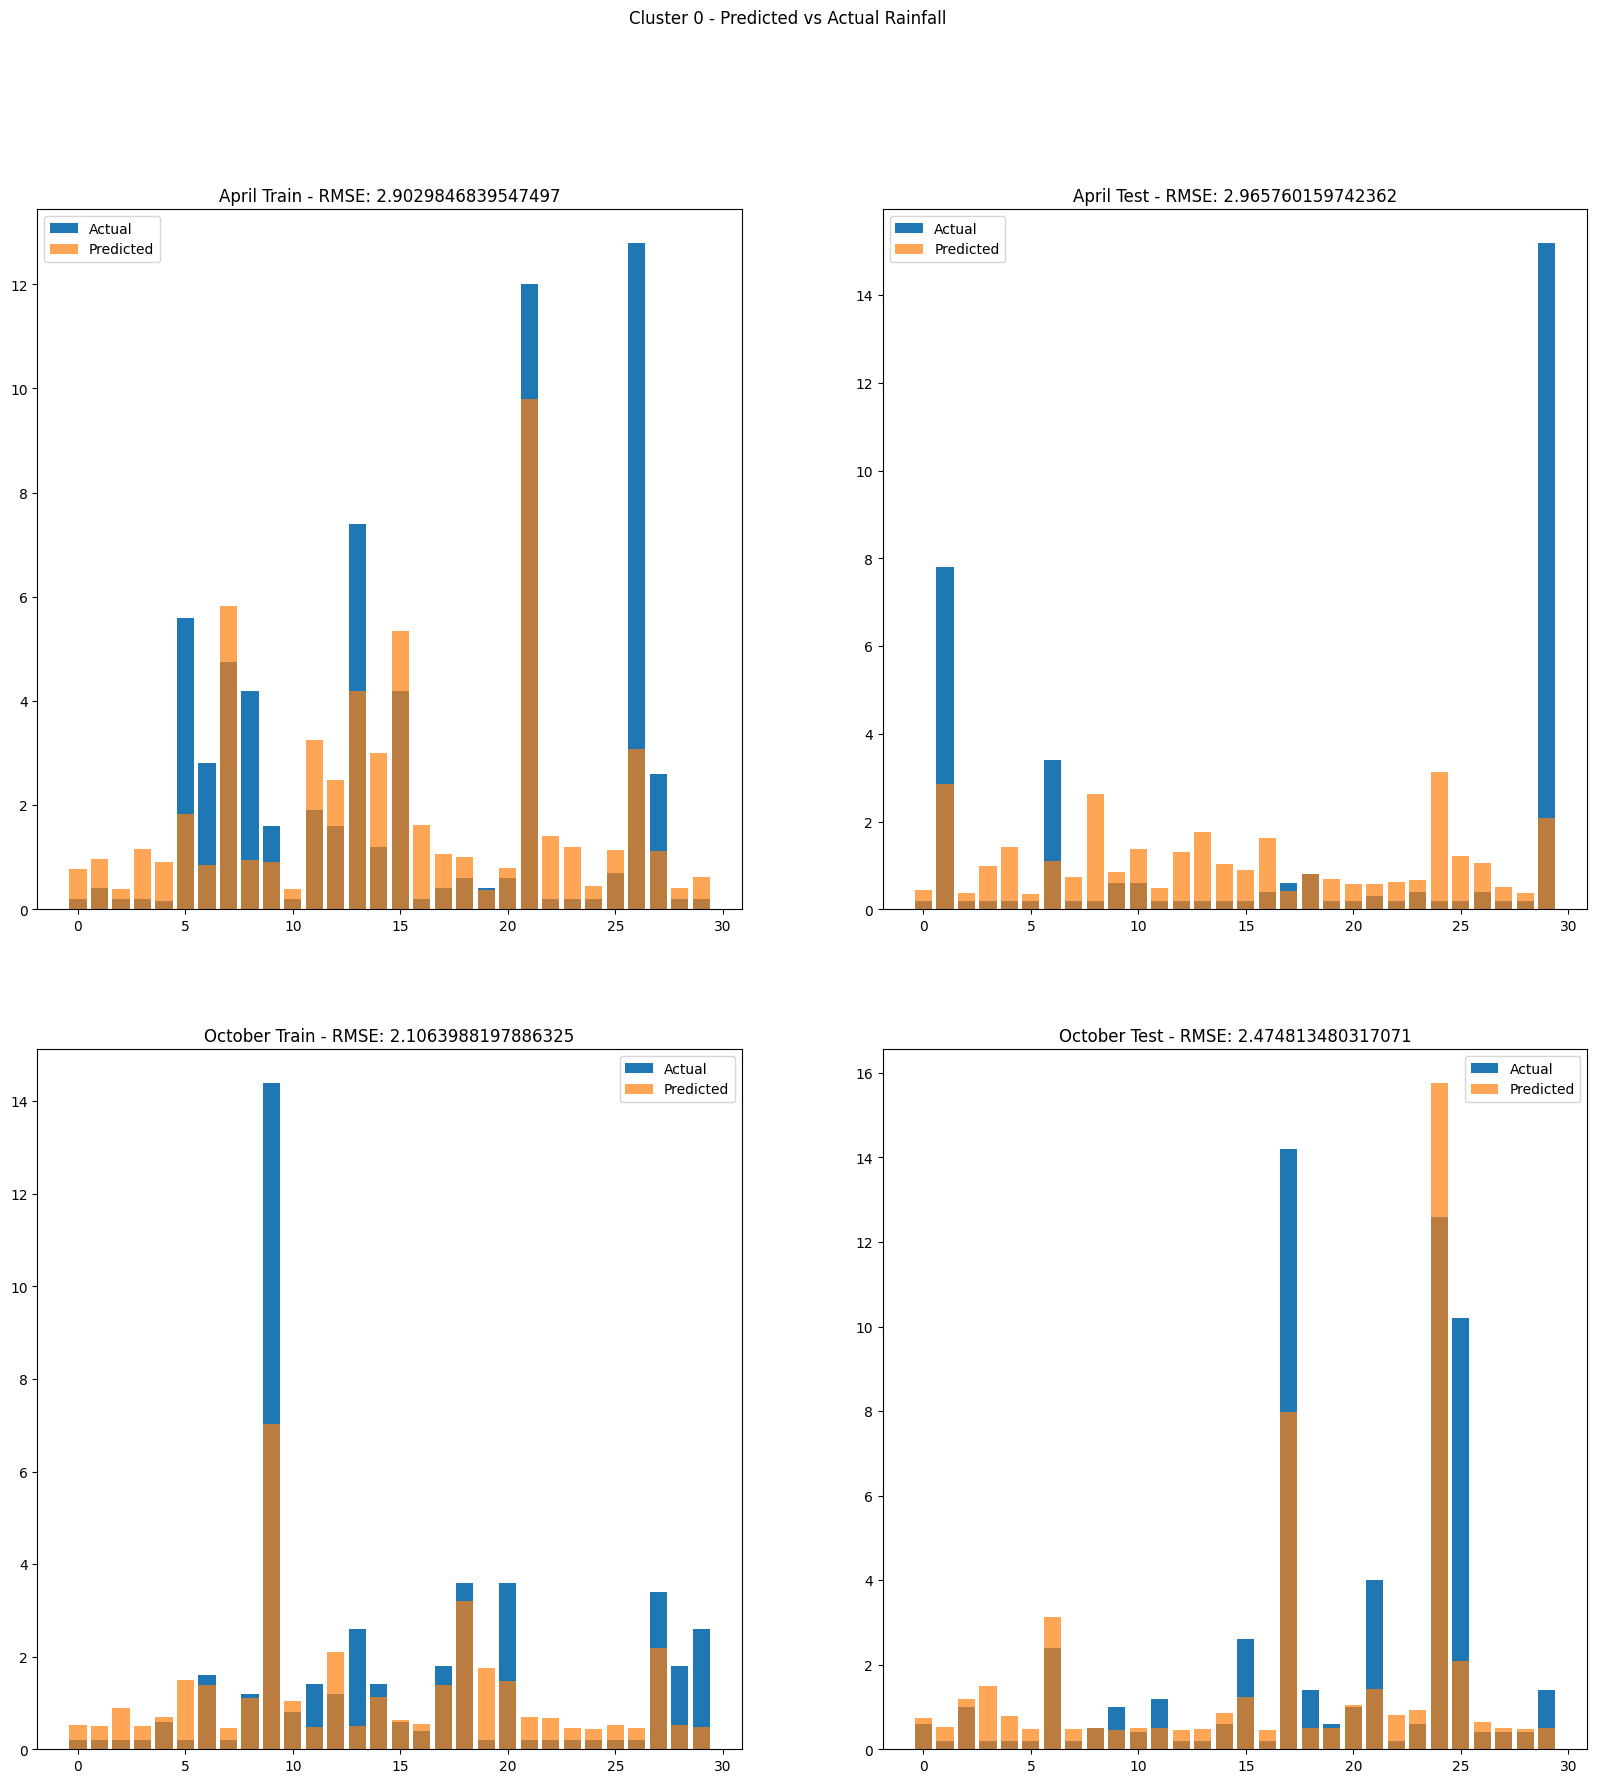

Cluster 1
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
April Train nan: 0
April Test nan: 0
October Train nan: 0
October Test nan: 0
April Train_pred mean: 2.011092185974121
April Test_pred mean: 2.2210121154785156
October Train_pred mean: 4.3199663162231445
October Test_pred mean: 4.3822197914123535


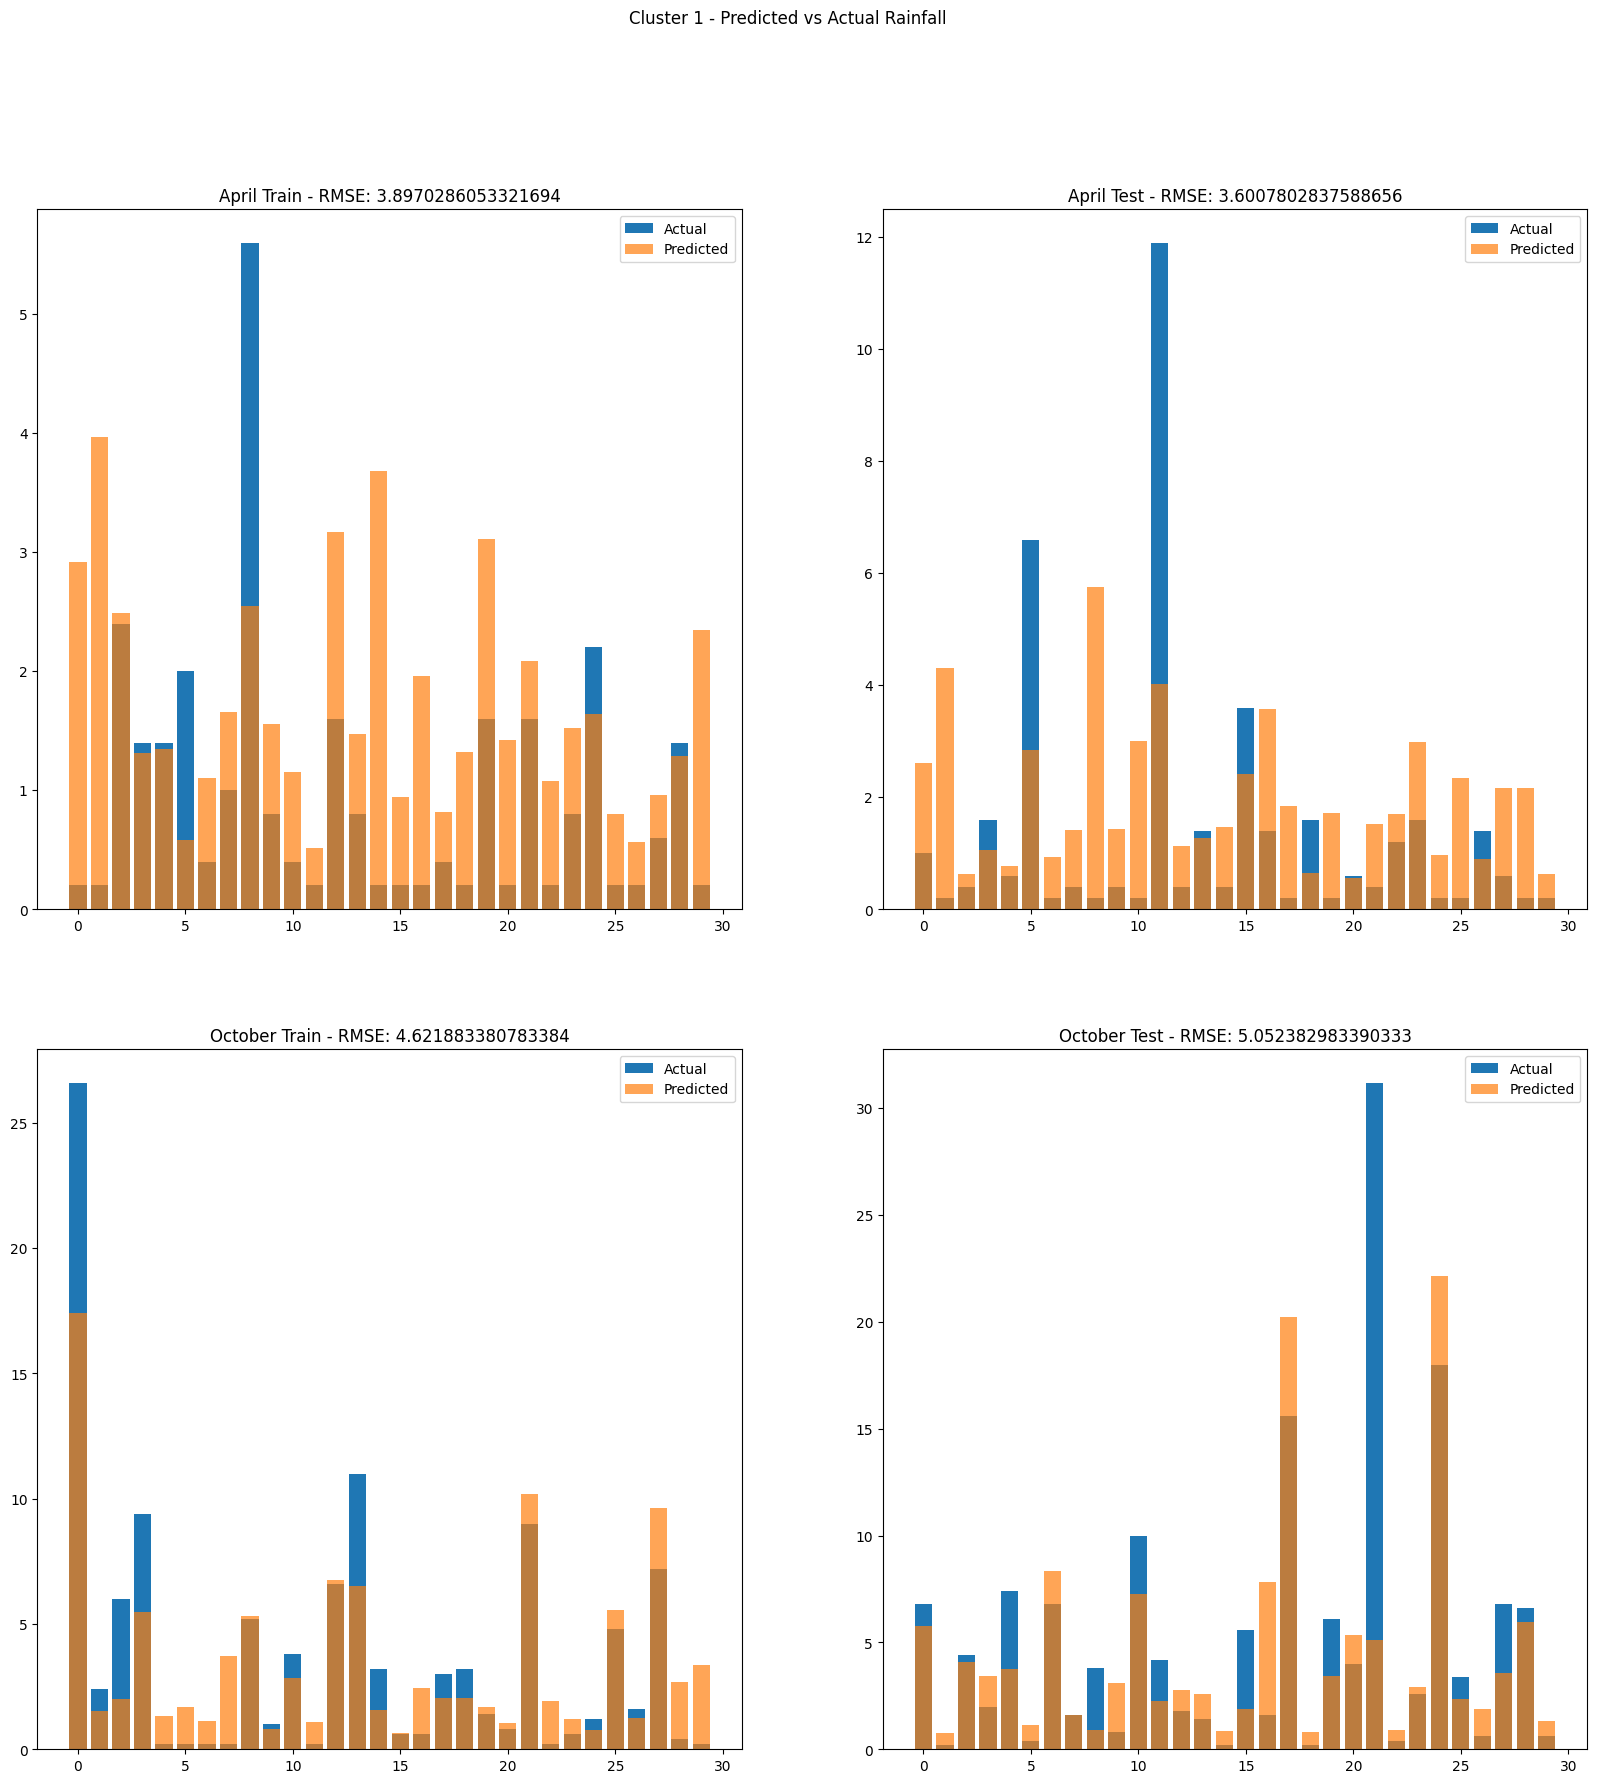

Cluster 2
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
April Train nan: 0
April Test nan: 0
October Train nan: 0
October Test nan: 0
April Train_pred mean: 1.1627388000488281
April Test_pred mean: 1.1131244897842407
October Train_pred mean: 2.19716215133667
October Test_pred mean: 2.1186487674713135


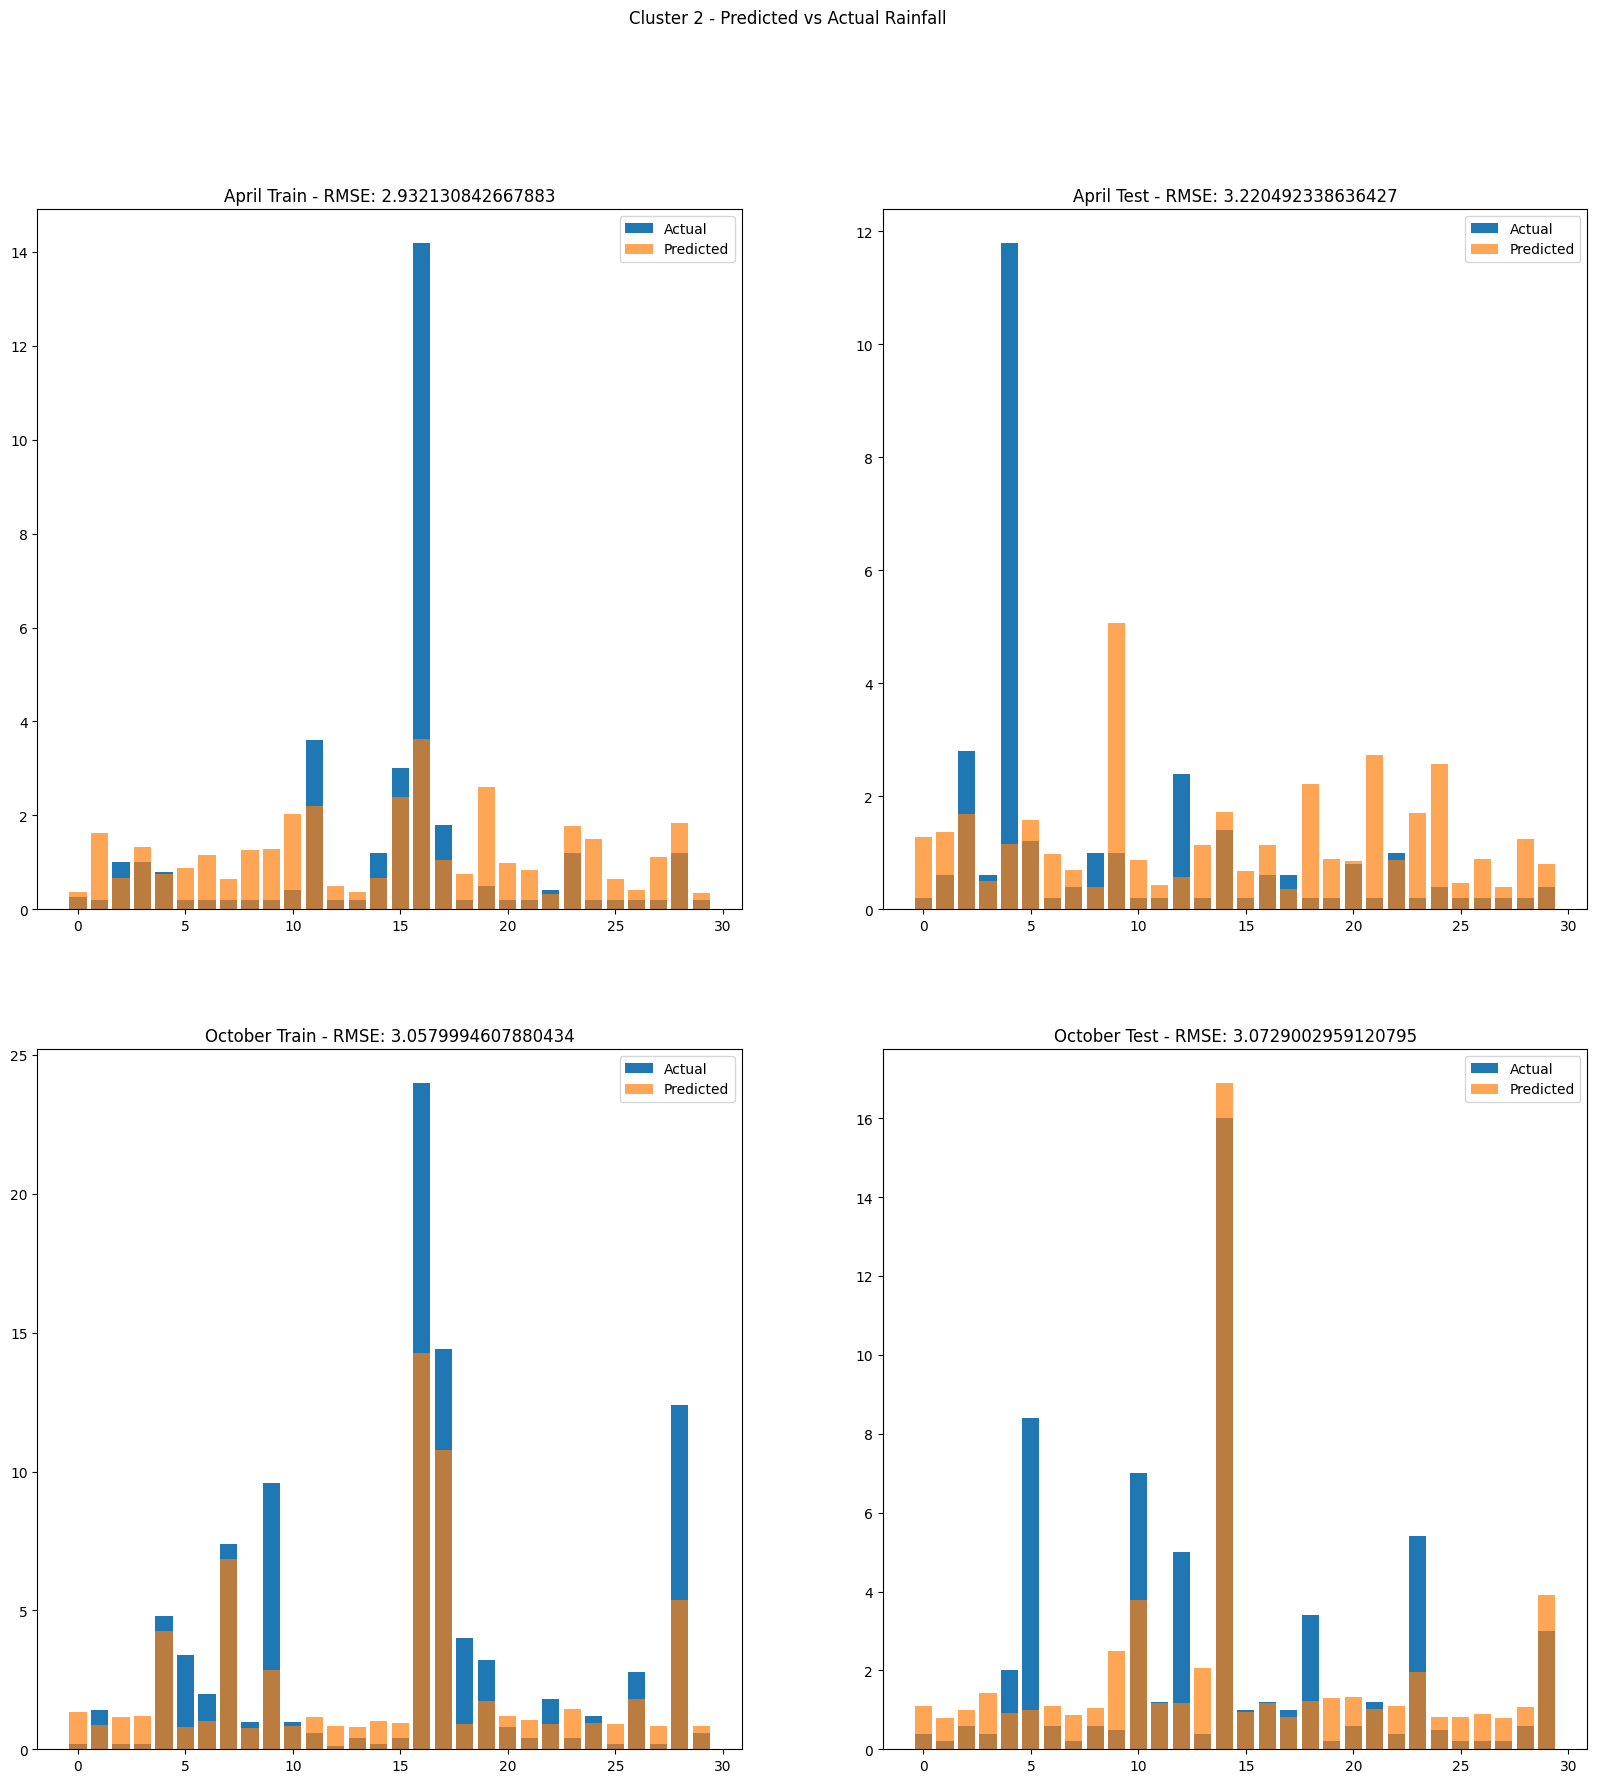

Cluster 3
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
April Train nan: 0
April Test nan: 0
October Train nan: 0
October Test nan: 0
April Train_pred mean: 1.1167418956756592
April Test_pred mean: 1.1375834941864014
October Train_pred mean: 1.8663198947906494
October Test_pred mean: 1.9934377670288086


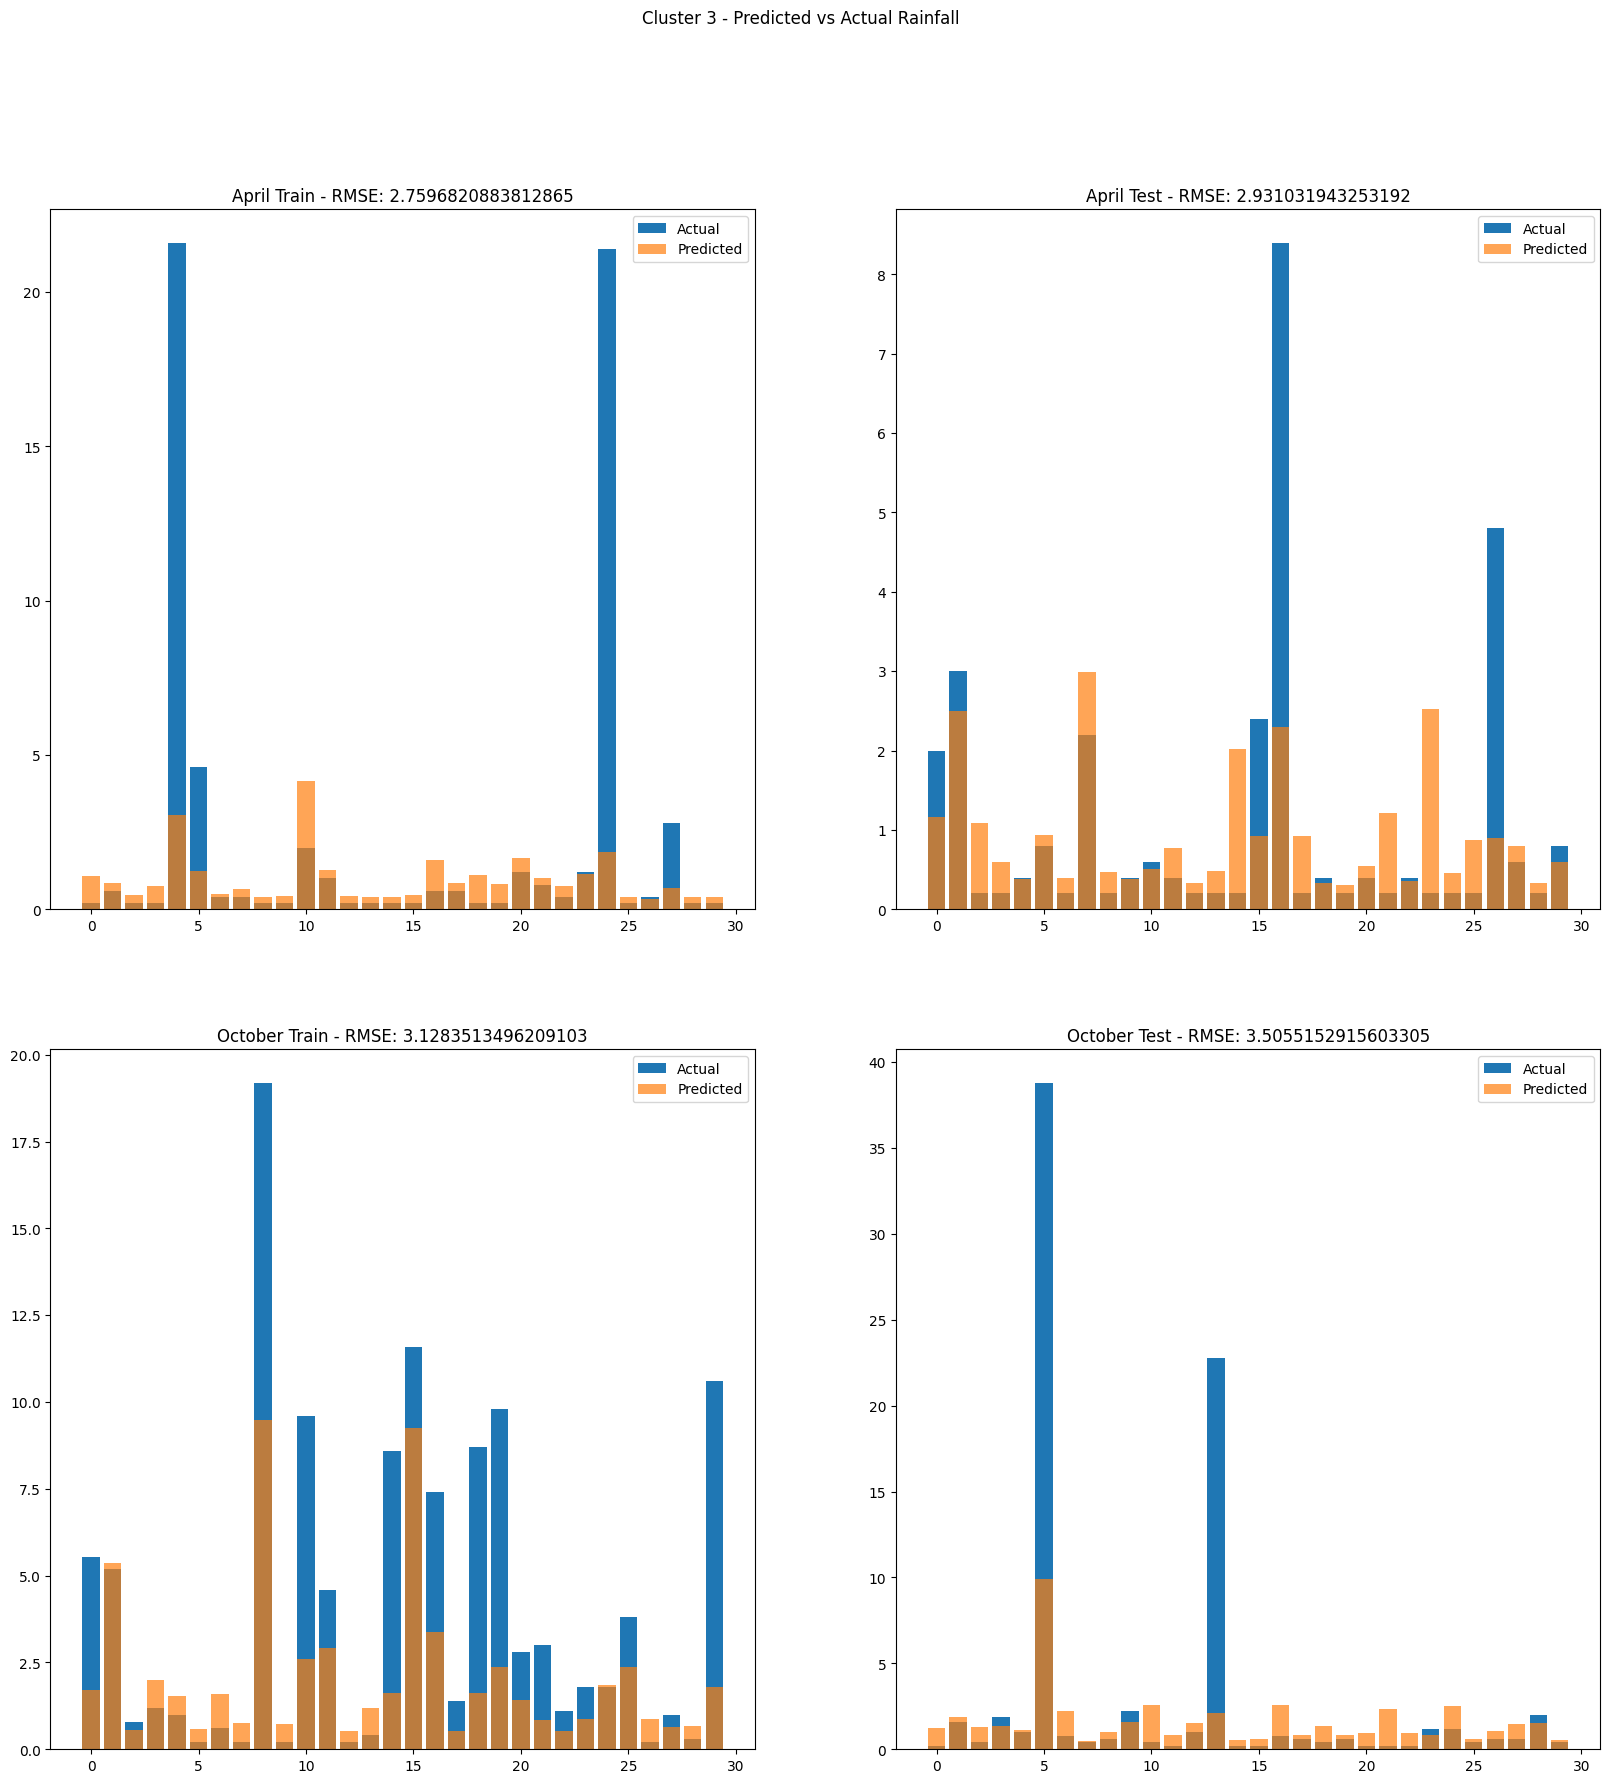

In [18]:
# Evaluate model
from sklearn.metrics import root_mean_squared_error

for i in range(N_CLUSTERS):
	print(f"Cluster {i}")
	april_model = regression_april_models[i]
	october_model = regression_october_models[i]
	april_X_train = regression_april_dataset_train_X[i]
	april_Y_train = regression_april_dataset_train_Y[i]
	april_X_test = regression_april_dataset_test_X[i]
	april_Y_test = regression_april_dataset_test_Y[i]
	october_X_train = regression_october_dataset_train_X[i]
	october_Y_train = regression_october_dataset_train_Y[i]
	october_X_test = regression_october_dataset_test_X[i]
	october_Y_test = regression_october_dataset_test_Y[i]
	april_train_pred = april_model.predict(april_X_train)
	april_test_pred = april_model.predict(april_X_test)
	october_train_pred = october_model.predict(october_X_train)
	october_test_pred = october_model.predict(october_X_test)
	april_train_rmse = root_mean_squared_error(april_Y_train, april_train_pred)
	april_test_rmse = root_mean_squared_error(april_Y_test, april_test_pred)
	october_train_rmse = root_mean_squared_error(october_Y_train, october_train_pred)
	october_test_rmse = root_mean_squared_error(october_Y_test, october_test_pred)

	# Print nan count
	print(f"April Train nan: {np.isnan(april_train_pred).sum()}")
	print(f"April Test nan: {np.isnan(april_test_pred).sum()}")
	print(f"October Train nan: {np.isnan(october_train_pred).sum()}")
	print(f"October Test nan: {np.isnan(october_test_pred).sum()}")
	# Print mean
	print(f"April Train_pred mean: {np.mean(april_train_pred)}")
	print(f"April Test_pred mean: {np.mean(april_test_pred)}")
	print(f"October Train_pred mean: {np.mean(october_train_pred)}")
	print(f"October Test_pred mean: {np.mean(october_test_pred)}")
	
	# Create subplots
	fig, axs = plt.subplots(2, 2, figsize=(20, 20))
	fig.suptitle(f'Cluster {i} - Predicted vs Actual Rainfall')

	# April Train
	axs[0, 0].bar(range(len(april_Y_train[-30:])), april_Y_train[-30:], label='Actual')
	axs[0, 0].bar(range(len(april_train_pred[-30:])), april_train_pred[-30:].flatten(), alpha=0.7, label='Predicted')
	axs[0, 0].set_title(f'April Train - RMSE: {april_train_rmse}')
	axs[0, 0].legend()

	# April Test
	axs[0, 1].bar(range(len(april_Y_test[-30:])), april_Y_test[-30:], label='Actual')
	axs[0, 1].bar(range(len(april_test_pred[-30:])), april_test_pred[-30:].flatten(), alpha=0.7, label='Predicted')
	axs[0, 1].set_title(f'April Test - RMSE: {april_test_rmse}')
	axs[0, 1].legend()

	# October Train
	axs[1, 0].bar(range(len(october_Y_train[-30:])), october_Y_train[-30:], label='Actual')
	axs[1, 0].bar(range(len(october_train_pred[-30:])), october_train_pred[-30:].flatten(), alpha=0.7, label='Predicted')
	axs[1, 0].set_title(f'October Train - RMSE: {october_train_rmse}')
	axs[1, 0].legend()

	# October Test
	axs[1, 1].bar(range(len(october_Y_test[-30:])), october_Y_test[-30:], label='Actual')
	axs[1, 1].bar(range(len(october_test_pred[-30:])), october_test_pred[-30:].flatten(), alpha=0.7, label='Predicted')
	axs[1, 1].set_title(f'October Test - RMSE: {october_test_rmse}')
	axs[1, 1].legend()

	plt.show()
	print("=" * 150)


# Note:
- Need refractoring (write function for \[X, y\] and scaling X_train, X_test)
- Split train & test before SMOTE-ENN (this has to be done on training samples)
- Classification before regression
- Select a fixed number of features